In [1]:
import sys
import numpy as np
from PIL import Image
from collections import Counter

def scale_image(self, scale):
  w, h = self.size
  return self.resize((int(scale*w),int(scale*h)), Image.Resampling.NEAREST)
setattr(Image.Image, "scale", scale_image)


HEAD_VAL = 2
NECK_VAL = 1
POLE_VAL = 6
HOLE_VAL = 4
EMPTY_VAL = 0


def compile(shape: np.ndarray):
  from scipy.ndimage import convolve
  KERNEL = np.array([[0, 1, 0],
                     [1, 0, 1],
                     [0, 1, 0]])
  nneighbours = convolve(
      shape.astype(bool).astype(int),
      KERNEL, mode='constant', cval=0)

  poles = ((nneighbours == 1) & (shape == 2))
  holes = ((nneighbours == 3) & (shape == 0))

  return shape | (poles << 2) | (holes << 2)


def count_holes(shape: np.ndarray):
  from scipy.ndimage import binary_fill_holes
  return (shape.astype(bool) != binary_fill_holes(shape)).sum()


def print_shape(shape: np.ndarray, file = sys.stdout):
  for row in shape:
    for cell in row:
      print(cell if cell != 0 else ' ', end=' ', file=file)
    print(file=file)


def shrink_shape(shape: np.ndarray):
  h = shape.any(axis=1).sum()
  w = shape.T.any(axis=1).sum()
  side = max(h, w) + 1
  return shape[:side, :side]


def read_shapes(filename: str, compile=False):
  COLOR_HEAD = (0, 0, 0, 255)
  COLOR_NECK = (63, 63, 116, 255)
  COLOR_POLE = (172, 50, 50, 255)
  COLOR_HOLE = (75, 105, 47, 255)
  COLOR_EMPTY = (0, 0, 0, 0)

  im = Image.open(filename)
  arr = np.asarray(im)
  heads_mask = (arr == COLOR_HEAD).all(axis=2)
  necks_mask = (arr == COLOR_NECK).all(axis=2)
  poles_mask = (arr == COLOR_POLE).all(axis=2)
  holes_mask = (arr == COLOR_HOLE).all(axis=2)

  res = np.zeros(arr.shape[:2], dtype=int)

  res[heads_mask] = HEAD_VAL
  res[necks_mask] = NECK_VAL

  res[poles_mask] = POLE_VAL if compile else HEAD_VAL
  res[holes_mask] = HOLE_VAL if compile else EMPTY_VAL

  BLOCK_SIZE = 16
  blocks = res.reshape(res.shape[0] // BLOCK_SIZE, BLOCK_SIZE,
                       res.shape[1] // BLOCK_SIZE, BLOCK_SIZE) \
      .transpose(0, 2, 1, 3)
  shapes = [
      shrink_shape(chunk)
      for row in blocks
      for chunk in row if chunk.any()
  ]
  shapes.sort(key=lambda x: (x.size, x.astype(bool).sum()), reverse=True)
  return shapes

def idshape_img(shape):
  def get_color(idx):
    if idx == 0: return (0, 0, 0, 0)
    idx = (idx*6 % 63)
    r, g, b = ((idx >> 4) & 0x3), ((idx >> 2) & 0x3), (idx & 0x3)
    r = 48*r + 32
    g = 48*g + 48
    b = 48*b + 64
    return r, g, b, 255
  arr = np.array([[get_color(cell) for cell in row] 
                  for row in shape], dtype=np.uint8)
  return Image.fromarray(arr) # pyright: ignore[reportCallIssue]


def print_image(im):
  def ansi_rgb(rgba):
    return "\x1b[38;2;{};{};{}m".format(*rgba[:3])
  for row in np.asarray(im):
    for cell in row:
      if not cell[:3].any():
        print("  ", end="")
      else:
        print(f"{ansi_rgb(cell)}[]", end="")
    print()
  print("\x1b[0m")


def shape_mask(shape: np.ndarray):
  return (shape & 0x3).astype(bool).astype(int)



def get_all_edges(shapes):
  from tqdm import tqdm
  shapes = [compile(shape) for shape in shapes]

  max_size = max(map(len, shapes))

  index_iter = tqdm(range(len(shapes)), total = len(shapes), ncols=64)

  edges = []
  for s1 in index_iter:
    shape_hole = np.pad(shapes[s1], pad_width=max_size, mode='constant',
                        constant_values=0)
    # print_shape(shape_hole)
    shape_hole_mask = shape_mask(shape_hole)
    x, y = np.where(shape_hole == HOLE_VAL)
    for xi, yi in zip(x, y):

      for s2 in range(len(shapes)):
        if s2 == s1:
          continue
        shape_con = shapes[s2]

        for i in range(4):
          shape_conn_mask = shape_mask(shape_con)
          xc, yc = np.where(shape_con == POLE_VAL)

          for xci, yci in zip(xc, yc):
            xx = xi - xci
            yy = yi - yci

            ss = np.array(shape_hole_mask)
            ss[xx:xx+len(shape_conn_mask), yy:yy+len(shape_conn_mask)] += \
                2*shape_conn_mask

            if (ss != 3).all():
              nholes = count_holes(ss)
              if nholes and nholes < 9000:
                continue

              edges.append(((s1, (xi - max_size, yi - max_size)), (s2, (xci, yci), i)))

          shape_con = np.rot90(shape_con)

  return edges

def trim_square(matrix: np.ndarray):
  matrix = matrix[~np.all(matrix == 0, axis=1)].T
  matrix = matrix[~np.all(matrix == 0, axis=1)].T
  rows, cols = matrix.shape

  max_dim = max(rows, cols)
  pad_rows = max_dim - rows
  pad_cols = max_dim - cols

  return np.pad(matrix, ((0, pad_rows), (0, pad_cols)), 
                         mode='constant', constant_values=0)

def join(shapes, edge):
  ((s1, (xi, yi)), (s2, (xci, yci), r2)) = edge
  shape_con = shapes[s2]
  max_size = len(shape_con)

  shape_hole = np.pad(shapes[s1], pad_width=max_size, mode='constant',
                      constant_values=0)
  shape_hole_mask = shape_mask(shape_hole)
  xi += max_size
  yi += max_size

  for _ in range(r2):
    shape_con = np.rot90(shape_con)
  shape_conn_mask = shape_mask(shape_con)
  xx = xi - xci
  yy = yi - yci

  ss = shape_hole
  ss[xx:xx+len(shape_con), yy:yy+len(shape_con)] += shape_con

  return trim_square(ss)

def join_all(shapes, edges):
  added = set()
  new_shapes = []
  used_edges = []
  for n1, n2 in edges:
    if n1[0] in added or n2[0] in added:
      continue
    added.add(n1[0])
    added.add(n2[0])
    new_shapes.append(join(shapes, (n1, n2)))
    used_edges.append((n1, n2))

  new_shapes.extend(shapes[i]
                    for i, shape in enumerate(shapes) 
                    if i not in added
  )
  return new_shapes, used_edges


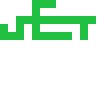

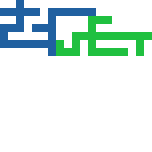

100%|███████████████████████████| 65/65 [00:06<00:00, 10.32it/s]


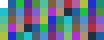

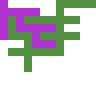

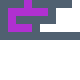

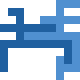

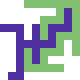

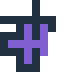

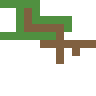

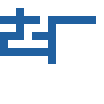

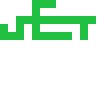

In [5]:

def imdisplay(im):
  try:
    if not sys.stdout.isatty():
      display(im.scale(8)) # type: ignore
      return
  except:
    pass
  
  def ansi_rgb(rgba):
    return "\x1b[38;2;{};{};{}m".format(*rgba[:3])
  for row in np.asarray(im):
    for cell in row:
      if not cell[:3].any():
        print("  ", end="")
      else:
        print(f"{ansi_rgb(cell)}[]", end="\x1b[0m")
    print()
  print()

shapes = read_shapes("pixel-fitit.png")
idshapes = [
  shape.astype(bool) * i
  for i, shape in enumerate(shapes, 1)
]

used_edges = []

jnd = join(idshapes, ((0, (3, 7)), (1, (0, 0), 0)))
imdisplay(idshape_img(idshapes[1]))
imdisplay(idshape_img(jnd))


def filter_edges(edges):
  counts = Counter(map(lambda x: x[0], edges))
  act_edges = list(filter(lambda x: counts[x[0]] == 1, edges))
  return act_edges

saves = []

while len(shapes) != 1:
  edges = get_all_edges(shapes)
  # join(shapes, (3, (3, 5), 39, (4, 6), 0))

  new_shapes = []
  new_idshapes = []

  act_edges = filter_edges(edges)
  new_shapes, used_now_edges = join_all(shapes, act_edges)
  used_edges.extend(used_now_edges)
  
  new_idshapes, used_now_edges = join_all(idshapes, used_now_edges)

  shapes = new_shapes
  idshapes = new_idshapes
  break


colors = np.array([range(5*13)], dtype=np.uint8)
arr = colors.reshape((5, 13))
imdisplay(idshape_img(arr))


# show_img(arr)
for shape in idshapes[:8]:
  imdisplay(idshape_img(shape))



In [65]:
import networkx as nx


def dump_dot(g: nx.DiGraph):
  lines = ["digraph {"]
  for node in g.nodes:
    lines.append(f'  "{node}";')
  for n1, n2 in g.edges:
    lines.append(f'  "{n1}" -> "{n2}";')
  lines.append("}")
  return "\n".join(lines)



In [ ]:
print()


False
